#Individual Work

Importing libraries needed for this CA.

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import stats

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

%matplotlib inline

In [ ]:
sns.set_theme(style="white")

In [ ]:
# Mount Drive to get access to file.
drive.mount('/content/drive')

Mounted at /content/drive


##Question 3: K-means and EM algorithms

###Write a python code to extract the clustering_data.csv file.

In [ ]:
# Global variables.
data_url = r'/content/drive/My Drive/Colab Notebooks/CA3/Individual Work/Clustering_data.csv'

In [ ]:
# Reading data from CSV file.
data = pd.read_csv(data_url)
data.head()

,Weight,Height
0,67.1,176.1
1,68.8,178.4
2,60.9,170.3
3,59.7,168.7
4,65.4,173.8


###Explore and visualise the data set.

In [ ]:
# Explore information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  500 non-null    float64
 1   Height  500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


The dataset is made up of 500 observations and two features: Weight and Height. The type of variable is continuous. There is no label, therefore it is needed to cluster observations (people) based on Weight and Height. Thus, this could lead to clustering the data by underweight, normal, and overweight (just an example as this also could cluster data into kid or adult).

In [ ]:
# Looking for missing data.
data.isna().sum()

Weight    0
Height    0
dtype: int64

There is no missing data in the two features. Now I am going to look for descriptive statistics to look for outliers/errors.

In [ ]:
data.describe()

,Weight,Height
count,500.0,500.0
mean,61.3,169.5
std,5.2,4.8
min,50.4,160.2
25%,57.8,166.6
50%,62.0,169.7
75%,65.4,172.8
max,70.7,178.9


As it is not specify the units of the data, I would take that Weight is in kilograms and Height is in centimeters. Therefore, there is no outliers as Height could have values from 50.4kg to 70.7kg and Height values from 160.2cm to 178.9cm. However, I am going to visualize data into a boxplot to check for outliers.

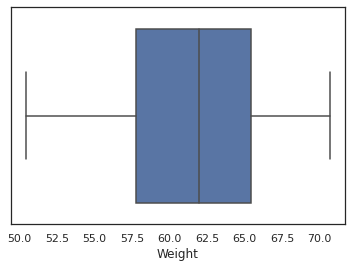

In [ ]:
# Plot for univariable, Weight
sns.boxplot(x=data["Weight"])
plt.show()

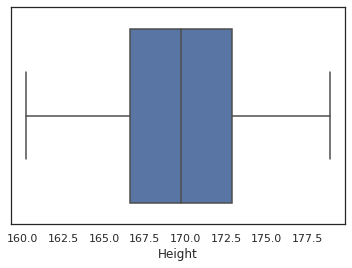

In [ ]:
# Plot for univariable, Height
sns.boxplot(x=data["Height"])
plt.show()

No outliers in features Weight and Height.
As the features are continuous, I am going to use an histagram to plot each feature and look at the distribution. Now, I am going to plot the information using an histagram to check out the distribution.

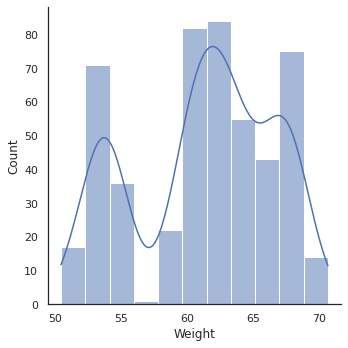

In [ ]:
# Plot for univariable, Weight
sns.displot(data=data, x="Weight", kde=True)
plt.show()

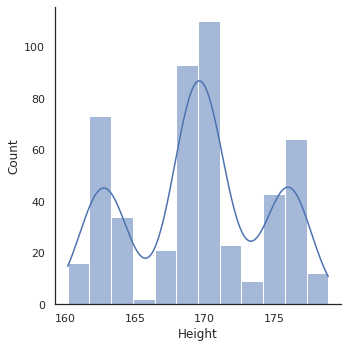

In [ ]:
# Plot for univariable, Height
sns.displot(data=data, x="Height", kde=True)
plt.show()

By looking at the histograms of each feature, it is clear that there are different distributions together, therefore using unsupervised learning models such as clustering will classify this information. This is more noticable when plotting both features in the scatterplot, as it looks there are clusters. 

NOTE: additionally, it seems this clusters have an oval shape, therefore k-mean cluster might perform bad.

NOTE 2: no normalization performed as the distribution of the data is not gaussian (no bell shape) [7].

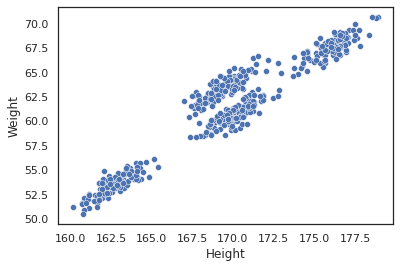

In [ ]:
# Plot for bivariables, Weight and Height
sns.scatterplot(data=data, x="Height", y="Weight")
plt.show()

###Use K-means and EM algorithm to cluster dataset.

#### K-means

First of all, I will determinate the number of clusters to use by looking at the scree plot and use the elbow method to pick the number of k values. 

In [ ]:
def plot_linegragh(X, y, title, xlabel, ylabel):
  # Plot results
  plt.plot(X, y)
  plt.title('Sceen Plot')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()

def getSSE_kmean(X, k, args):
  kmeans = KMeans(n_clusters=k, **args)
  kmeans.fit(X)
  return kmeans.inertia_

In [ ]:
# Get array values
X = data.values

wcss = []
n_ks = 10 # Number of times I will create a KMeans model to compare to others and show sceen plot to select cluster using elbow method.
n_components = range(1, n_ks+1)

# initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
# Also this is used to avoid initialization trap to correctly select the centroids.
init_method = 'k-means++'

seed = 16 # Determines random number generation for centroid initialization.

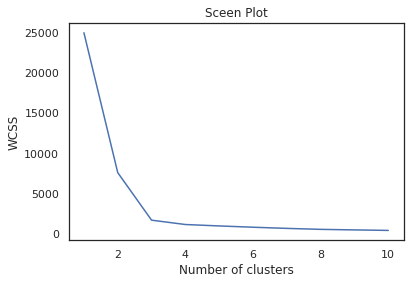

In [ ]:
# Train model for each n_ks clusters, then get the WCSS to plot in a Sceen Plot to choose k.
kmeans_kwargs = {
    "init": init_method,
    #"n_init": 10,
    #"max_iter": 300,
    "random_state": seed,
}

for i in n_components:
    SSE = getSSE_kmean(X, i, kmeans_kwargs)
    wcss.append(SSE) # Sum of squared distances of samples to their closest cluster center.

plot_linegragh(n_components, wcss, 'Sceen Plot', 'Number of clusters', 'WCSS')

By looking at the scree plot and using the "Elbow" method, it seems the best option for k-means clustering is k=3.

In [ ]:
# Train model on dataset
k=3 # number choosen by elbow method
kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
y_km = kmeans.fit_predict(X)

# Show number of clusters
set(y_km)

{0, 1, 2}

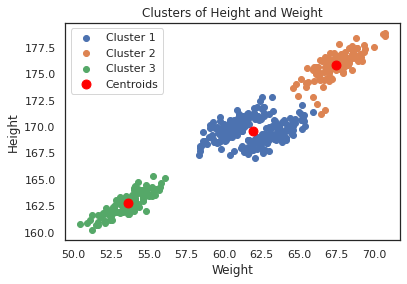

In [ ]:
# Create list of colors
pal = sns.color_palette()
color_list = pal.as_hex()

# Plot data, colour clusters and centroids.
for i in range(0,k):
  plt.scatter(x=X[y_km==i, 0], y=X[y_km==i, 1], c=color_list[i], label='Cluster '+str(i+1))
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=80, c='red', label='Centroids')

# Add title and labels to axis
plt.title('Clusters of Height and Weight')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend(loc='best')
plt.show()

#### EM Algorithm

First of all, I will determinate the number of clusters to use by looking at the scree plot and use the elbow method to pick the number of k values. 

In [ ]:
gmm_bic = []
gmm_aic = []

n_ks = 10
n_components = np.arange(1, n_ks+1)

# type of parameters to use, as it is assume each component has its own general parameter.
# it allows each cluster to be modeled as an ellipse with arbitrary orientation
type_co = 'full' 

seed = 5 # Determines random number generation for centroid initialization.

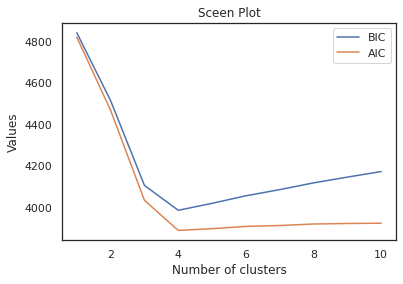

In [ ]:
# code from ML lecture
gmm_kwargs = {
    'covariance_type': type_co, 
    'random_state': seed
}

for n in n_components:
  gmm = GaussianMixture(n_components=n, **gmm_kwargs)
  gmm.fit(X)

  gmm_bic.append(gmm.bic(X))
  gmm_aic.append(gmm.aic(X))

# Plot results
plt.plot(n_components, gmm_bic, label='BIC')
plt.plot(n_components, gmm_aic, label='AIC')

# Plot title and axis labels
plt.ylabel('Values')
plt.xlabel('Number of clusters')
plt.title('Sceen Plot')
plt.legend(loc='best')
plt.show()

By looking at the scree plot, it seems the best option is k=4, as the AIC and BIC values started increasing after cluster 4.

In [ ]:
# Train model on dataset
k = 4 # number choosen by elbow method
gmm = GaussianMixture(n_components=k, **gmm_kwargs)
y_gmm = gmm.fit_predict(X)

# Show number of clusters
set(y_gmm)

{0, 1, 2, 3}

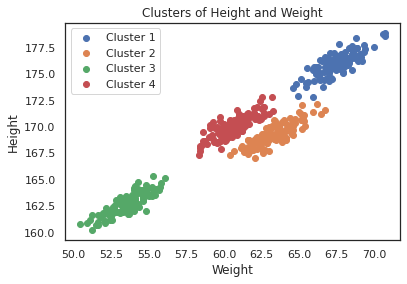

In [ ]:
# Create list of colors
pal = sns.color_palette()
color_list = pal.as_hex()

# Plot data, colour clusters and centroids.
for i in range(0,k):
  plt.scatter(x=X[y_gmm==i, 0], y=X[y_gmm==i, 1], c=color_list[i], label='Cluster '+str(i+1))

# Add title and labels to axis
plt.title('Clusters of Height and Weight')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend(loc='best')
plt.show()

###Discuss the outcomes.
* By looking straight away at the scatter plot, it is noticeable that there are clusters in the dataset and somewhat there were 4 clusters (groups, sources, or classes).
* What was interesting is the shape of the data on the scatterplot, as it has an oval form, therefore I could assume that K-means would not classify properly the data as k-means tents to have a circle shape in contrast to GMM, where we can define the shape with the property covariance_type when using *sklean.Gaussian Mixture* module. Therefore, the best model for this dataset is the GMM as this could cluster the data into 4 noticeable groups. 
* Additionally, GMM is a soft clustering model, therefore it is more flexible as it used probability or likelihood assigned for the data points in each cluster.

###Is it possible to use some pre-processing technique to improve the performance of K-means clustering?
Yes. A way to improve K-means clustering could be:
* Transforming the data: log, sqrt.
* Using cross feature.
* Normalization of the data (generally, getting the z-score to make the data unitless. This also improve computing process).
* If there are many features in the dataset, use dimensional reduction methods such as PCA.
* Using Quantiles on an uncategorizable distribution prior to any preprocessing. Divide the data into intervals where each interval contains an equal number of examples. These interval boundaries are called quantiles [7].

## Question 5: Discuss the following

###Two approaches to learn the label from unlabelled data?
There are different ways to label unlabelled datasets. Examples are:
* **Clustering** methods. As we have seen in Machine Learning Lecture, there are different clustering algorithms to which elements belong together. Examples are k-mean clustering, Gaussian Mixture Model, and Hierarchical clustering.
* **Dimensionality Reduction** technics. This is used to simplify a dataset with high dimensionality. An example of this is the Principal Component Analysis, useful to identify patterns in data.

###Can we use SVM to classify MNIST dataset?
- **Yes**, it is possible to classify the MNIST dataset using Support Vector Machine. 
- An option is using the library sklearn import the modules **svm** and **model_selection.GridSearchCV** (helps to loop through predefined hyperparameters and fit model on your training set) [6].

###How can you evaluate a Model in Machine Learning?
There are different ways to evaluate a model in ML.
* A common way to evaluate a supervised learning model is by looking at the accuracy and loss value when comparing models (e.g., after tuning hyper-parameters). 
* When there is a classification problem, it is a good idea to additionally check out the confusion matrix (false Positives and true false Negatives).
* For unlabelled data, there is no specific answer as I think it depends on the data and the algorithm selected.

# References

[1]. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

[2]. https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

[3]. https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

[4]. https://stackoverflow.com/questions/47412749/how-can-i-get-a-representative-point-of-a-gmm-cluster

[5]. https://www.edupristine.com/blog/k-means-algorithm

[6]. https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01

[7]. https://developers.google.com/machine-learning/clustering/prepare-data



